# 월평균 초임 임금에 따른 청년의 퇴사율
- 임금 수준이 낮은 청년 근로자일수록 1년 미만 퇴사율이 높은가?
<br>
- 목적 : 청년 정규직 근로자 중, 평균 임금 이하에 해당하는 비율이 높을수록 1년 미만 근속자 비율(조기퇴사율)도 높아지는가?를 확인


#### 🎈변수 정의
| 변수         | 설명                                           |
| ---------- | -------------------------------------------- |
| **저임금 비율** | 평균 임금 이하 근무자 비율(`해당 연도 평균임금 이하 구간의 인원 수 / 전체 청년 근무자 수`)      |
| **조기퇴사율**  | 1년 미만 근속자의 비율 (`1년 미만 근속자 수 / 전체 근로자 수`) |


In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 기본 테마 설정
# https://coldbrown.co.kr/2023/07/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%8B%A4%EC%A0%84%ED%8E%B8-08-seaborn-sns-set%EC%9D%84-%ED%86%B5%ED%95%B4-%EC%8A%A4%ED%83%80%EC%9D%BC-%EC%84%A4%EC%A0%95%ED%95%98%EA%B8%B0/
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

# 복잡한 통계 처리를 위한 라이브러리
from scipy import stats

## ✍저임금 비율
+ 경제활동 인구 中 실업자 : 퇴사율
+ 평균 임금 이하의 근로자 : 임금 수준이 낮은 청년 근로자

#### 1. 연도별 청년 평균임금 추출

In [ ]:
# 월 평균 초임 임금 starting salary
salary = pd.read_excel("data/성별 첫일자리 월평균임금(17 ~ 24년).xlsx")

In [3]:
salary.columns

Index(['연령구분', '성별', '월평균 임금', '2017.05', '2018.05', '2019.05', '2020.05',
       '2021.05', '2022.05', '2023.05', '2024.05'],
      dtype='object')

In [4]:
# 데이터 뒤에 .05 제거
salary_cols = salary.columns.str.replace('.05', '')

# 컬럼명을 salary_cols로 변경
salary.columns = salary_cols

In [5]:
# 결측치 처리: ffill() - 앞의 값을 채움
s_salary = salary.ffill()

# 연령구분이 15~29세, 성별이 계인 경우의 데이터 추출
age1529 = s_salary[(s_salary['연령구분'] == '15~29세') & (s_salary['성별'] == '계')]

# 연령구분이랑 성별 컬럼 삭제
age1529 = age1529.drop(columns=['연령구분', '성별'])

In [6]:
age1529 = age1529.drop(index=0).reset_index(drop=True)
age1529

,월평균 임금,2017,2018,2019,2020,2021,2022,2023,2024
0,50만원 미만,140,175,214,230,183,167,132,158
1,50~100만원 미만,546,560,522,498,481,463,379,359
2,100~150만원 미만,1537,1288,1156,966,812,663,620,489
3,150~200만원 미만,1216,1399,1421,1424,1501,1506,1408,1245
4,200~300만원 미만,569,633,755,833,939,1168,1236,1324
5,300만원 이상,93,85,101,119,140,151,171,190


#### 2. 평균 이하 비율 계산
- 각 연도별로 평균임금 이하 구간에 속하는 청년 근로자의 비율
- (평균이하인원/전체인원)


In [ ]:
salary_mean = pd.read_excel("data/연령별_평균임금.xlsx")
salary_mean
salary_mean.columns

In [8]:
salary_mean = salary_mean[1:]
salary_mean = salary_mean.drop(columns=['고용형태', '연령'])
salary_mean

,2017,2018,2019,2020,2021,2022,2023,2024
1,1979,2116,2222,2221,2265,2471,2580,2601


In [9]:
print(age1529["월평균 임금"].unique())

['50만원 미만' '50~100만원 미만' '100~150만원 미만' '150~200만원 미만' '200~300만원 미만'
 '300만원 이상']


In [10]:
wage_median = { # 중앙값 사용 => 가중 평균 계산
    '50만원 미만' : 25,
    '50~100만원 미만' : 75,
    '100~150만원 미만' : 125,
    '150~200만원 미만' : 175,
    '200~300만원 미만' : 250,
    '300만원 이상' : 300
}
# 월평균 임금에 중앙값 적용
age1529["중앙값"] = age1529["월평균 임금"].map(wage_median)

In [11]:
salary_mean_dict = salary_mean.iloc[0].to_dict()
salary_mean_dict = {int(year): val / 10 for year, val in salary_mean_dict.items()}


In [12]:
for year in salary_mean_dict:
    avg_salary = salary_mean_dict[year]
    print(year, (age1529["중앙값"] <= avg_salary).sum())

2017 4
2018 4
2019 4
2020 4
2021 4
2022 4
2023 5
2024 5


In [13]:
below_ratios = {}

for year in [str(y) for y in range(2017, 2025)]:
    avg_salary = salary_mean_dict[int(year)]
    total = age1529[year].sum() # 해당 년도에서 전체 청년 근로자 수의 합
    below_avg = age1529[age1529["중앙값"] <= avg_salary][year].sum() # 청년 근로자 중 평균 이하의 수
    below_ratios[year] = round(below_avg / total, 4) # 평균 이하 비율 계산 

below_df = pd.DataFrame(list(below_ratios.items()), columns=['연도', '평균 이하 비율'])
print(below_df)

     연도  평균 이하 비율
0  2017    0.8386
1  2018    0.8266
2  2019    0.7947
3  2020    0.7661
4  2021    0.7340
5  2022    0.6797
6  2023    0.9567
7  2024    0.9495


In [14]:
below_df['평균 이하 비율'] = below_df['평균 이하 비율'] * 100

### 🎨시각화

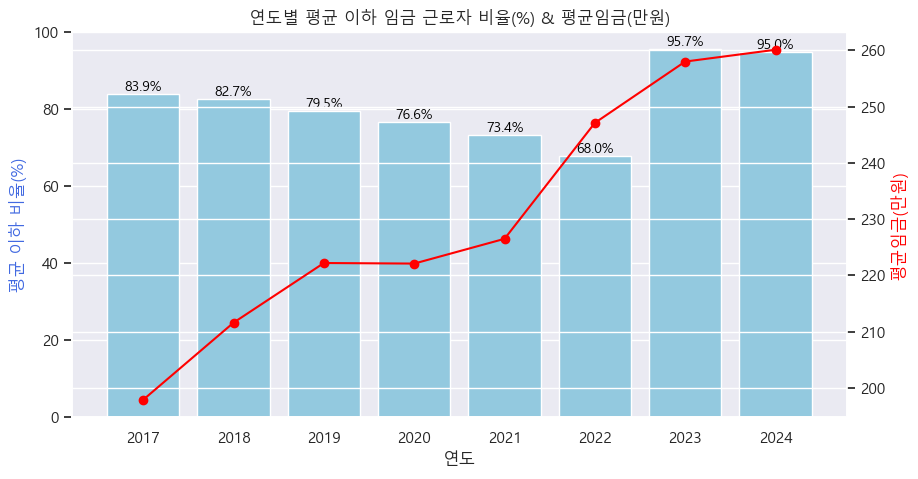

In [15]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# 평균 이하 비율(막대)
bar = sns.barplot(data=below_df, x='연도', y='평균 이하 비율', color='skyblue', ax=ax1)
ax1.set_ylabel('평균 이하 비율(%)', color='royalblue')
ax1.set_ylim(0, 100)

# 막대 위에 값 표시
for p in bar.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.1f}%', 
                 (p.get_x() + p.get_width() / 2, height), 
                 ha='center', va='bottom', fontsize=10, color='black')

# 평균임금(선, 보조축)
years = [str(y) for y in salary_mean_dict.keys()]
salary_means = list(salary_mean_dict.values())
ax2 = ax1.twinx()
ax2.plot(years, salary_means, color='red', marker='o', label='평균임금')
ax2.set_ylabel('평균임금(만원)', color='red')

plt.title('연도별 평균 이하 임금 근로자 비율(%) & 평균임금(만원)')
plt.show()

#### 결과 &Downarrow; 평균 임금은 증가하고 있지만 평균 이하 임금을 받는 사람은 늘고 있음
- 어? 그러면 이에 불만족스러워서 퇴사율이 증가할 수 있겠네?
- 아니면 다른 데이터로 한번 더 해보자

---

## ✍조기 퇴사율
#### 1년 미만 퇴사율 계산

In [ ]:
# 근속기간
c_employment = pd.read_excel("data/근로형태별 평균근속기간 및 근속기간별 구성비.xlsx")
c_employment

In [17]:
# 2017.08.2 ~ 2024.08.2 : 1년 미만

cols_1 = [] # 1년 미만(XXXX.XX.02) 리스트 저장 => 컬럼으로 쓸 예정

# 2017~2024 1년 미만 컬럼명 저장
for i in range(2017, 2025):
    cols_1.append(f'{i}.08.2')

ce1 = c_employment[cols_1]
cols = ce1.columns.str.replace('.08.2', '')
ce1.columns = cols
ce1


,2017,2018,2019,2020,2021,2022,2023,2024
0,1년미만,1년미만,1년미만,1년미만,1년미만,1년미만,1년미만,1년미만
1,31.1,30.9,32.2,31.2,32.2,31.6,30.3,29.1
2,19.9,19,18.5,16.9,17.7,17.7,16.7,15.1
3,54.1,54.9,56.3,56.1,55.5,54.8,53.3,51.6
4,49.5,50.9,55.4,53.5,52.9,53.3,53.2,53
5,51.5,53.2,58.9,53.5,53,53.4,53,52.8
6,42.3,42.1,41.9,53.2,52.5,53.2,55.7,54.8
7,63.8,64.6,63.5,65.3,64.9,64.2,61,58.9
8,57.8,59.4,58.5,61.1,60.7,57.2,54.6,51.9


- 1년 미만 퇴사율 계산
- 지금 내가 구해놓은 것은 임금이 평균보다 낮은 사람들의 비율
- 그러면 이제 1년 미만 퇴사율을 구해서 저임금 비울과 1년 미만 퇴사율의 관계를 분석하면 됨